In [1]:
import healpy as hp
from pysm3 import units as u
import pysm3
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy.table import QTable

In [3]:
chs = QTable.read("../instrument_model/instrument_model.tbl", format="ascii.ipac")

In [4]:
# chs = chs[chs["telescope"]=="SAT"]

In [5]:
from astropy.io import fits

In [6]:
chs.add_index("band")

In [7]:
gal2eq = hp.Rotator(coord="GC")

In [8]:
co_line_230_input =(gal2eq.rotate_map_alms(
            hp.smoothing(
            hp.ud_grade(hp.read_map("/mnt/home/azonca/s/pysm-data/co/HFI_CompMap_CO-Type1_2048_R2.00_ring.fits", 1), 512), fwhm=np.radians(1))) * u.K_CMB).to(u.uK_CMB)

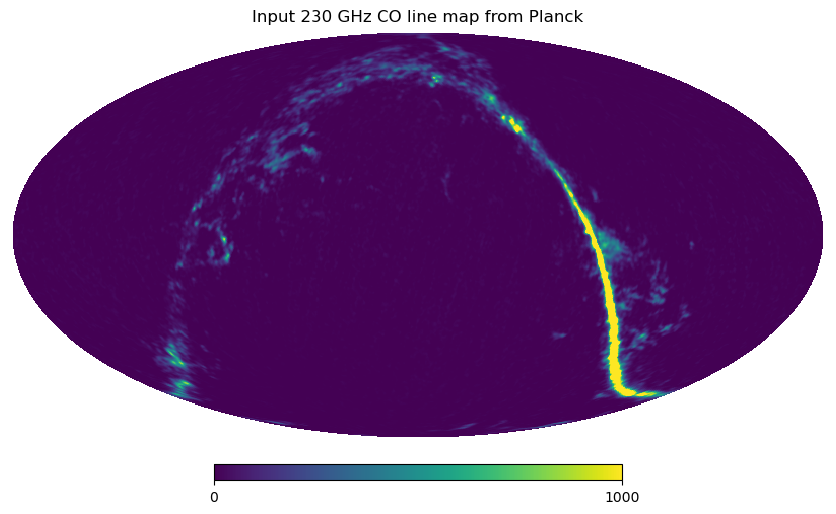

In [9]:
hp.mollview(co_line_230_input, min=0, max=1000, title="Input 230 GHz CO line map from Planck")

In [10]:
from glob import glob

In [12]:
for ch in chs:
    for model in ["co1", "co3"]:
        print(ch["band"], model)
        m = pysm3.read_map(glob(f"../output/co_{model}/*{ch['band']}*co_{model}*healpix*.fits")[0], nside=512, field=(0,1,2))

        # hp.mollview(m[0].value, min=0, max=10, unit=m.unit, title="CO low complexity")

        if u.allclose(m,0 * u.uK_CMB):
            print("No CO emission")
        else:

            # hp.mollview(m[0]/co_line_230_input, min=-100,max=100)

            bandpass = QTable.read(f"../instrument_model/{ch['bandpass_file']}", format="ascii.ipac")

            bandpass.add_index("bandpass_frequency")

            # plt.axvline(0.022, color="black")
            # plt.hist(m[0]/co_line_230_input, 1000, range=[0,.1]);

            bandwidth = bandpass.iloc[-1]["bandpass_frequency"] - bandpass.iloc[0]["bandpass_frequency"]

            median_map_scale = np.median(m[0]/co_line_230_input)

            mean_band_normalization = pysm3.normalize_weights(bandpass["bandpass_frequency"].value, bandpass["bandpass_weight"]).mean()

            ratio = median_map_scale/mean_band_normalization
            
            print(f"CO Emission is {median_map_scale:.2g} compared to the Planck map, given the bandpass we expect roughly {mean_band_normalization:.2g}, the ratio is {ratio:.3g}")
            
            if model == "co1":
                assert u.allclose(m[1:], 0*u.uK_CMB), "CO1 should be unpolarized"
            else:
                median_map_scale_pol = np.median(np.sqrt(m[1]**2+m[2]**2)/m[0])
                print(f"In polarization (expected less than .1% due to depolarization): {median_map_scale_pol:.2e}")
                assert median_map_scale_pol < .1/100 and median_map_scale_pol > .01/100

030 co1
No CO emission
030 co3
No CO emission
044 co1
No CO emission
044 co3
No CO emission
070 co1
No CO emission
070 co3
No CO emission
100 co1
CO Emission is 0.014 compared to the Planck map, given the bandpass we expect roughly 0.033, the ratio is 0.416
100 co3
CO Emission is 0.014 compared to the Planck map, given the bandpass we expect roughly 0.033, the ratio is 0.416
In polarization (expected less than .1% due to depolarization): 3.25e-04
143 co1
No CO emission
143 co3
No CO emission
217 co1
CO Emission is 0.022 compared to the Planck map, given the bandpass we expect roughly 0.013, the ratio is 1.64
217 co3
CO Emission is 0.022 compared to the Planck map, given the bandpass we expect roughly 0.013, the ratio is 1.64
In polarization (expected less than .1% due to depolarization): 3.02e-04
353 co1
CO Emission is 0.0081 compared to the Planck map, given the bandpass we expect roughly 0.0073, the ratio is 1.1
353 co3
CO Emission is 0.0081 compared to the Planck map, given the band